# 1. Objectives

1. Predict Seeding based on Season Statistics. Analyze leading predictors of seeding outcome.
2. Predict Tournament Results Based on Seeding and Season Statistics. Do not worry about matchups.
3. Test Models on 2021 data.

# 2. Importing and Cleaning the Data

For my project, I want to predict college basketball tournament seeding and national champions based on the season's stastics. From kaggle.com, there are available data sets from the 2013-2021 basketball seasons (excluding 2020 due to cancelled tournament). The columns of the data set with associated descriptions are as follows:
- TEAM: name of team being analyzed
- CONF: name of conference the team plays for
- G: Games played
- W: Games won
- ADJOE: Adjusted Offensive Efficiency (Estimate of Average Points Scored per 100 Posessions)
- ADJDE: Adjusted Defensive Efficiency (Estimate of Average Points Allowed per 100 Posessions)
- BARTHAG: Power Rating (Chance of Beating an average D1 team)
- EFG_O: Field Goal Percentage
- EFG_D: Field Goal Percentage Allowed
- TOR: Turnover Percentage
- TORD: Steal Rate
- ORB: Offensive Rebound Rate
- DRB: Defensive Rebound Rate
- FTR: Free Throw Rate
- FTRD: Free Throw Rate Allowed
- 2P_O: Two-Point Shooting Percentage
- 2P_D: Two-Point Shooting Percentage Allowed
- 3P_O: Three-Point Shooting Percentage
- 3P_D: Three-Point Shooting Percentage Allowed
- ADJ_T: Adjusted Tempo (Posessions per 40 minutes)
- WAB: Wins Above Bubble (Wins against top teams)
- POSTSEASON: Result of Tournament
- SEED: Seed in the NCAA March Madness Tournament
- YEAR: Which year the data was drawn from

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#data set from https://www.kaggle.com/andrewsundberg/college-basketball-dataset?select=cbb.csv
rawdata = pd.read_csv("https://github.com/kharmer9/IST652_Final/raw/main/cbb.csv") #2013-2019 seasons
rawdata.head(10)

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017
5,Kentucky,SEC,40,29,117.2,96.2,0.9062,49.9,46.0,18.1,...,36.8,50.0,44.9,33.2,32.2,65.9,3.9,2ND,8.0,2014
6,Michigan,B10,38,30,121.5,93.7,0.9522,54.6,48.0,14.6,...,22.7,53.4,47.6,37.9,32.6,64.8,6.2,2ND,4.0,2013
7,Duke,ACC,39,35,125.2,90.6,0.9764,56.6,46.5,16.3,...,23.9,55.9,46.3,38.7,31.4,66.4,10.7,Champions,1.0,2015
8,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,...,26.3,52.5,45.7,39.5,28.9,60.7,11.1,Champions,1.0,2019
9,North Carolina,ACC,39,33,121.0,91.5,0.9615,51.7,48.1,16.2,...,31.6,51.0,46.3,35.5,33.9,72.8,8.4,Champions,1.0,2017


In [3]:
for col in rawdata.columns: #cycles through columns
    if sum(rawdata[col].isna()) != 0: #detecting any NAs
        print(col) #printing any column with an NA
    elif sum(rawdata[col].isnull()) != 0: #detecting and NULL
        print(col) #printing any column with a NULL (that did not already register with NA)
        
for i in range(len(rawdata.duplicated())): #all rows
    if rawdata.duplicated()[i] == True: #filtering to duplicates for each row
        print("Entry " + str(i) + " is duplicated.") #printing row index

POSTSEASON
SEED


It is okay that SEED and POSTSEASON have some empty columns; not all teams can make the tournament or get to the Elite 8. There are no visible duplications. Now, let's check that the data set is complete.

In [4]:
# We have 68 teams that make the tournament every year and 7 years to consider. So we should have 476 teams that receive seeds.
if (rawdata.shape[0] - sum(rawdata["SEED"].isna())) == 476:
    print("All seeds are recorded.")
    
# Additionally, we should see 476 tournament results
if (rawdata.shape[0] - sum(rawdata["POSTSEASON"].isna())) == 476:
    print("All Postseasons are recorded.")

All seeds are recorded.
All Postseasons are recorded.


The data set appears to be complete. If it was not, NA's would be interpolated based on their team average (conference if team was unavailable). If the results showed any extreme discrepencies based on that filtering, the points (school) would be removed all together. Duplicated occurances would also be removed.

In [5]:
data = rawdata #adding columns to the data set

In [40]:
SEEDSCORE = rawdata["SEED"] #new series to add score into project
SEEDSCORE[rawdata["SEED"].isna()] = 17 # setting all teams that did not make tournament to 17 seed
SEEDSCORE = SEEDSCORE.to_numpy().astype(float) #converting series to array with float input for math
data["SEEDSCORE"] = 17 - SEEDSCORE #17-seedscore --> linearly increasing seedscore (0 as no tournament appearance to 16 for 1 seed)

data["SEED"][rawdata["SEED"].isna()] = "NTA" #no tournament appearance

'''
#Total Games Before Loss Adjustment; will see for 2021 analysis, but not initial models
TGBL = rawdata["POSTSEASON"]
for a in range(len(data["POSTSEASON"])):
    if data["POSTSEASON"][a] == "Champions":
        TGBL[a] = 7.0
    elif data["POSTSEASON"][a] == "R68":
        TGBL[a] = 0.0
    elif data["POSTSEASON"][a] == "R64":
        TGBL[a] = 1.0
    elif data["POSTSEASON"][a] == "R32":
        TGBL[a] = 2.0
    elif data["POSTSEASON"][a] == "S16":
        TGBL[a] = 3.0
    elif data["POSTSEASON"][a] == "E8":
        TGBL[a] = 4.0
    elif data["POSTSEASON"][a] == "F4":
        TGBL[a] = 5.0
    elif data["POSTSEASON"][a] == "2ND":
        TGBL[a] = 6.0
    else:
        TGBL[a] = 0.0
data["TGBL"] = TGBL.to_numpy().astype(float)
'''

data["POSTSEASON"][rawdata["POSTSEASON"].isna()] = "NTA" #no tournament appearance
data["POSTSEASON"] = data["POSTSEASON"].astype(object) #factorizing postseason variable

data["TEAM"] = data["TEAM"].astype(object) #factorizing team
data["CONF"] = data["CONF"].astype(object) #factorizing conference

C:\Users\kharm\AppData\Local\Temp/ipykernel_11156/3544532601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SEEDSCORE[rawdata["SEED"].isna()] = 17 # setting all teams that did not make tournament to 17 seed
C:\Users\kharm\AppData\Local\Temp/ipykernel_11156/3544532601.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["SEED"][rawdata["SEED"].isna()] = "NTA" #no tournament appearance
C:\Users\kharm\AppData\Local\Temp/ipykernel_11156/3544532601.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [122]:
data.groupby("YEAR").agg("mean")

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,...,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,SEEDSCORE
YEAR,,,,,,,,,,,,,,,,,,,,,
2013,31.475504,15.737752,100.804611,100.806052,0.495413,48.536023,48.742651,20.025937,19.954755,31.599424,...,35.970605,36.227666,47.460231,47.670029,33.724207,33.952450,65.954467,-7.993948,15.397695,1.602305
2014,31.356125,15.678063,104.584900,104.584046,0.495318,49.481197,49.686895,18.371795,18.281197,31.167521,...,40.473219,40.800285,48.458689,48.659544,34.294302,34.506553,66.595726,-7.439886,15.418803,1.581197
2015,31.333333,15.666667,102.315385,102.311681,0.493902,48.973789,49.180627,19.125641,19.039886,30.862963,...,37.043305,37.326781,47.732194,47.917379,34.165527,34.402564,64.936467,-7.764957,15.410256,1.589744
2016,31.430199,15.712251,103.866382,103.866382,0.492795,49.777208,49.970085,18.184046,18.119943,29.618234,...,36.638177,36.936182,48.661823,48.823077,34.537892,34.729630,69.100855,-7.821652,15.407407,1.592593
2017,31.538462,17.002849,103.840456,103.841880,0.492494,50.381197,50.573219,18.594017,18.543305,29.120798,...,35.328205,35.642450,49.283191,49.436467,34.860969,35.054131,69.481766,-7.847293,15.410256,1.589744
2018,31.566952,17.068376,104.354986,104.357265,0.494586,50.866667,51.062963,18.448718,18.379772,28.543590,...,33.537607,33.770940,49.937322,50.074074,34.966952,35.123647,69.419373,-7.968376,15.410256,1.589744
2019,31.745042,17.113314,103.335977,103.336261,0.493214,50.600850,50.774504,18.606516,18.523513,28.245892,...,32.954391,33.202550,50.060057,50.233994,34.287819,34.415864,69.168555,-7.783569,15.419263,1.580737


In [133]:
data.drop(columns = ["YEAR", "ADJ_T","TOR","TORD","3P_O","3P_D","FTR","FTRD","2P_O","2P_D","ORB","DRB"]).corr() #columns were removed based on observed lack or correlation (needed to view all columns)

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,WAB,SEED,SEEDSCORE
G,1.000000,0.724819,0.605112,-0.607700,0.693992,0.337732,-0.472541,0.664089,-0.550802,0.550802
W,0.724819,1.000000,0.752293,-0.693442,0.827366,0.607659,-0.593197,0.911297,-0.621660,0.621660
ADJOE,0.605112,0.752293,1.000000,-0.483926,0.860405,0.732286,-0.294531,0.839252,-0.611865,0.611865
ADJDE,-0.607700,-0.693442,-0.483926,1.000000,-0.837534,-0.188506,0.796335,-0.794511,0.551414,-0.551414
BARTHAG,0.693992,0.827366,0.860405,-0.837534,1.000000,0.534765,-0.616040,0.941104,-0.617256,0.617256
EFG_O,0.337732,0.607659,0.732286,-0.188506,0.534765,1.000000,-0.081205,0.551550,-0.351238,0.351238
EFG_D,-0.472541,-0.593197,-0.294531,0.796335,-0.616040,-0.081205,1.000000,-0.614901,0.400614,-0.400614
WAB,0.664089,0.911297,0.839252,-0.794511,0.941104,0.551550,-0.614901,1.000000,-0.703696,0.703696
SEED,-0.550802,-0.621660,-0.611865,0.551414,-0.617256,-0.351238,0.400614,-0.703696,1.000000,-1.000000
SEEDSCORE,0.550802,0.621660,0.611865,-0.551414,0.617256,0.351238,-0.400614,0.703696,-1.000000,1.000000


# 3. Data Manipulation

### 3a. Adjusting Data for Seeding Analysis

In [41]:
seeddata = data.drop(columns = ["POSTSEASON"]) #taking all of the data related to seeding
YEARTEAM = [] #new index
for a in range(len(rawdata)):
    YEARTEAM.append(str(seeddata["YEAR"][a])+ " " + str(seeddata["TEAM"][a])) #year of team as index
seeddata["YEARTEAM"] = YEARTEAM #adding column
#seeddata = seeddata.drop(columns = ["YEAR","TEAM"])
seeddata = seeddata.set_index("YEARTEAM") #setting column as index
seeddata.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR,SEEDSCORE
YEARTEAM,,,,,,,,,,,,,,,,,,,,,
2016 North Carolina,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1.0,2016,16.0
2015 Wisconsin,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1.0,2015,16.0
2018 Michigan,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,3.0,2018,14.0
2019 Texas Tech,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,3.0,2019,14.0
2017 Gonzaga,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,1.0,2017,16.0


Now to adjust data based on statistical findings:

In [42]:
from sklearn.model_selection import train_test_split

# some data dropped is based on outside statistical analysis
seedX = seeddata.drop(columns = ["YEAR","EFG_D","TORD","DRB","FTRD","2P_O","2P_D","3P_O","3P_D","ADJ_T","SEED","SEEDSCORE"]) #seed predictor set
seedy = seeddata["SEEDSCORE"] #seedscore

sXtrain, sXtest, sytrain, sytest = train_test_split(seedX, seedy, test_size=0.25, random_state = 1) #splitting into training and testing

### 3b. Adjusting Data for the Postseason Analysis

In [43]:
resultdata = data #result data
YEARTEAM = [] #new index
for a in range(len(rawdata)):
    YEARTEAM.append(str(resultdata["YEAR"][a])+ " " + str(resultdata["TEAM"][a])) #year for team
resultdata["YEARTEAM"] = YEARTEAM #new column in df
for a in range(resultdata.shape[0]):
    if resultdata["POSTSEASON"][a] == "NTA": #no tournament appearance --> dropping value
        resultdata = resultdata.drop(a, axis = 0)
resultdata = resultdata.set_index("YEARTEAM") #setting year team as index
resultdata.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,SEEDSCORE
YEARTEAM,,,,,,,,,,,,,,,,,,,,,
2016 North Carolina,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016,16.0
2015 Wisconsin,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015,16.0
2018 Michigan,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018,14.0
2019 Texas Tech,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019,14.0
2017 Gonzaga,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017,16.0


In [44]:
# will include seeding initially even with colinearity
# data used is based on external statsitical analysis
resultX = resultdata.drop(columns = ["YEAR","EFG_O","EFG_D","TOR","TORD","ORB","FTR","FTRD","2P_O","2P_D","3P_O","3P_D","ADJ_T","POSTSEASON","SEED"]) #predictor data
resulty = resultdata["POSTSEASON"] #postseason data to be predicted

rXtrain, rXtest, rytrain, rytest = train_test_split(resultX, resulty, test_size=0.25, random_state = 1) #splitting into training and testing set

# 4. Support Vector Machines

In [45]:
from sklearn import decomposition #variable decomposition for SVM
from sklearn.preprocessing import StandardScaler #variable decomposition for SVM
from sklearn.model_selection import GridSearchCV #parameter tuning function
from sklearn.svm import SVC #support vector machine function
from sklearn.metrics import accuracy_score #accuracy of model

### 4a. Seeding Predictions

In [46]:
sScale = StandardScaler() #scale for seeding svm
sScale.fit(sXtrain.drop(columns = ["TEAM","CONF"])) #sitting the scaling
sXtrain_scale = sScale.transform(sXtrain.drop(columns = ["TEAM", "CONF"])) #transforming the train data for the reduction
sXtest_scale = sScale.transform(sXtest.drop(columns = ["TEAM", "CONF"])) #transforming the test data for the reduction

In [47]:
svm_param = {'C': [0.01, 0.05, 0.1, 0.2], #regularization parameter
              'degree': [1, 2, 3], #possible degrees of polynomial if "poly" kernel is used
              'gamma': [1, 3, 5], #kernel coefficient
              'kernel': ["linear","poly","rbf"], #kernel for algorithm
              'probability': [True]} #parameters to test for svm

grid_search1 = GridSearchCV(SVC(), svm_param, cv=3, n_jobs=10, #3 folds running 10 inputs at a time
                          return_train_score=True, scoring='accuracy', verbose=2) #running through parameters for svm

grid_search1.fit(sXtrain_scale, sytrain) #using data to find best fit

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=10,
             param_grid={'C': [0.01, 0.05, 0.1, 0.2], 'degree': [1, 2, 3],
                         'gamma': [1, 3, 5],
                         'kernel': ['linear', 'poly', 'rbf'],
                         'probability': [True]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [48]:
print("Best parameters: " + str(grid_search1.best_params_)) #best parameters
print("Best cross-validation score: " + str(grid_search1.best_score_)) #with best accuracy

Best parameters: {'C': 0.2, 'degree': 1, 'gamma': 5, 'kernel': 'poly', 'probability': True}
Best cross-validation score: 0.8256372515157473


In [49]:
svmseed = SVC(**grid_search1.best_params_) #new model with parameters

svmseed.fit(sXtrain_scale,sytrain) #fitting training data
seedpred = svmseed.predict(sXtest_scale) #prediction test set

In [50]:
print("accuracy:", accuracy_score(sytest,seedpred)) #accuracy

accuracy: 0.8501628664495114


### 4b. Result Predictions

In [51]:
rScale = StandardScaler() #results scaling
rScale.fit(rXtrain.drop(columns=["TEAM","CONF"])) #fitting it to the reslts training data
rXtrain_scale = rScale.transform(rXtrain.drop(columns=["TEAM","CONF"])) #scaling results training data
rXtest_scale = rScale.transform(rXtest.drop(columns = ["TEAM","CONF"])) #scaling results testing data

In [52]:
grid_search2 = GridSearchCV(SVC(), svm_param, cv=3, n_jobs=10,
                          return_train_score=True, scoring='accuracy', verbose=2) #parameter tuning with same variables

grid_search2.fit(rXtrain_scale,rytrain) #fitting the training data

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=10,
             param_grid={'C': [0.01, 0.05, 0.1, 0.2], 'degree': [1, 2, 3],
                         'gamma': [1, 3, 5],
                         'kernel': ['linear', 'poly', 'rbf'],
                         'probability': [True]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [53]:
print("Best parameters: " + str(grid_search2.best_params_)) #best parameters
print("Best cross-validation score: " + str(grid_search2.best_score_)) #with best accuracy

Best parameters: {'C': 0.2, 'degree': 1, 'gamma': 1, 'kernel': 'linear', 'probability': True}
Best cross-validation score: 0.5742296918767508


In [54]:
svmresult = SVC(**grid_search2.best_params_) #using the model parameters with strongest cross-validation accuracy

svmresult.fit(rXtrain_scale,rytrain) #fitting the data to model
resultpred = svmresult.predict(rXtest_scale) #predicting the tesing data

In [55]:
print("SVM Accuracy:", accuracy_score(rytest,resultpred)) #accuracy between given and predicted data

SVM Accuracy: 0.6386554621848739


# 5. Decision Tree Classifiers

In [56]:
from sklearn.tree import DecisionTreeClassifier #decision tree classification
from sklearn import tree

### 5a. Seeding Predictions

In [57]:
#depth = 16 for different seeding options, min samples at 20 for at least 20 observations in training set for each seed
seed_tree = DecisionTreeClassifier(max_depth = 16,min_samples_leaf=20,random_state=1)
seed_tree.fit(sXtrain.drop(columns = ["TEAM","CONF"]),sytrain) #training model

DecisionTreeClassifier(max_depth=16, min_samples_leaf=20, random_state=1)

In [58]:
seed_tree_pred = seed_tree.predict(sXtest.drop(columns = ["TEAM","CONF"])) #predicting seeding

print("Decision Tree Accuracy of Testing Set: " + str(accuracy_score(sytest,seed_tree_pred))) #test accuracy

Decision Tree Accuracy of Testing Set: 0.8452768729641694


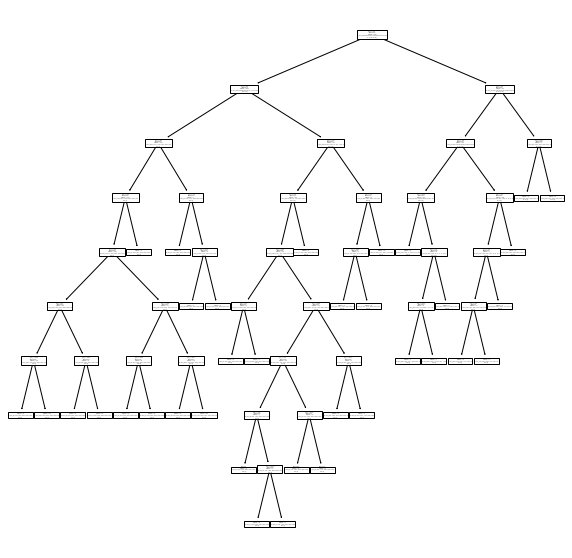

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10,10])
seedplot = tree.plot_tree(seed_tree) #tree diagram!

### 5b. Results Predictions

In [60]:
result_tree = DecisionTreeClassifier(max_depth = 7,random_state=1) #depth of 7 to compensate for each area of seeding
result_tree.fit(rXtrain.drop(columns = ["TEAM","CONF"]),rytrain) #using the training data

DecisionTreeClassifier(max_depth=7, random_state=1)

In [61]:
result_tree_pred = result_tree.predict(rXtest.drop(columns = ["TEAM","CONF"])) #predicting values using model

print("Decision Tree Accuracy of Testing Set: " + str(accuracy_score(rytest,result_tree_pred))) #test accuracy

Decision Tree Accuracy of Testing Set: 0.4957983193277311


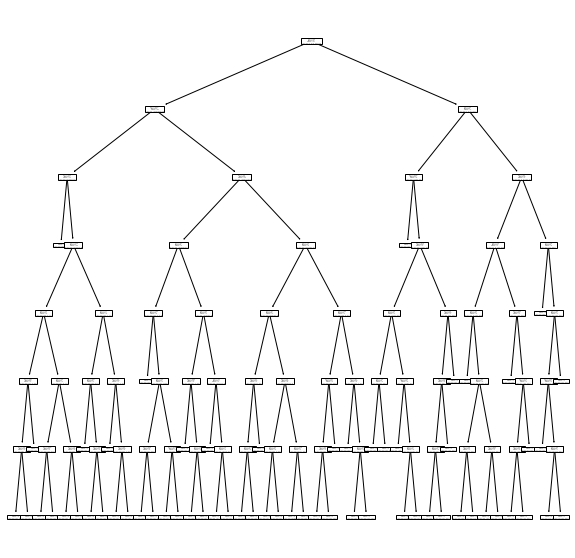

In [62]:
plt.figure(figsize=[10,10]) #decision tree #2
resultplot = tree.plot_tree(result_tree)

# 6. K-Nearest Neightbor

In [63]:
from sklearn.neighbors import KNeighborsClassifier #K-Nearest Neighbor

### 6a. Seed Projections

In [64]:
knn_param = {'n_neighbors': [2, 3, 4, 5], #approximate number of neighbors
              'metric': ["euclidean", "manhattan", "minkowski"]}

grid_search3 = GridSearchCV(KNeighborsClassifier(n_jobs=17), knn_param, cv=3, 
                          return_train_score=True, scoring='accuracy') #17 jobs for 17 seeding combinations

grid_search3.fit(sXtrain.drop(columns=["TEAM","CONF"]), sytrain) #fitting training data to find parameters

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=17),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [2, 3, 4, 5]},
             return_train_score=True, scoring='accuracy')

In [65]:
print("Best parameters: " + str(grid_search3.best_params_)) #best parameters
print("Best cross-validation score: " + str(grid_search3.best_score_)) #with best accuracy

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best cross-validation score: 0.8120623905146013


In [66]:
seedknn = KNeighborsClassifier(**grid_search3.best_params_) #new model with parameters

seedknn.fit(sXtrain.drop(columns = ["TEAM","CONF"]), sytrain) #fitting the training data
seed_knn_pred = seedknn.predict(sXtest.drop(columns = ["TEAM","CONF"])) #predicting the testing data
print("K - Nearest Neighbors Accuracy:", accuracy_score(sytest,seed_knn_pred)) #accuracy

K - Nearest Neighbors Accuracy: 0.8338762214983714


### 6b. Result Projections

In [67]:
grid_search4 = GridSearchCV(KNeighborsClassifier(n_jobs=8), knn_param, cv=3, #K-means tuning with 8 total possibilities
                          return_train_score=True, scoring='accuracy')

grid_search4.fit(rXtrain.drop(columns=["TEAM","CONF"]), rytrain) #fitting training data to find parameters

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=8),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [2, 3, 4, 5]},
             return_train_score=True, scoring='accuracy')

In [68]:
print("Best parameters: " + str(grid_search4.best_params_)) #best parameters
print("Best cross-validation score: " + str(grid_search4.best_score_)) #with best accuracy

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best cross-validation score: 0.5042016806722689


In [69]:
resultknn = KNeighborsClassifier(**grid_search4.best_params_) #new model with parameters

resultknn.fit(rXtrain.drop(columns = ["TEAM","CONF"]), rytrain) #fitting to the training data
result_knn_pred = resultknn.predict(rXtest.drop(columns = ["TEAM","CONF"])) #test predictions
print("K - Nearest Neighbors Accuracy:", accuracy_score(rytest,result_knn_pred)) #accuracy

K - Nearest Neighbors Accuracy: 0.5294117647058824


# 7. Testing with 2021


In [5]:
lydata = pd.read_csv("https://github.com/kharmer9/IST652_Final/raw/main/cbbdata.csv") #2021 data without tournament results
lydata.head() #Last Year's Data

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
0,Michigan,B10,24,20,118.1,91.1,0.9521,54.9,44.9,16.3,...,24.8,28.9,24.5,53.3,42.3,38.7,33.5,66.9,7.2,1.0
1,Baylor,B12,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,...,30.9,27.0,31.7,54.1,48.1,41.8,34.0,68.8,6.6,1.0
2,Illinois,B10,29,23,117.7,90.4,0.9539,55.6,46.6,18.2,...,22.2,39.2,30.5,55.3,45.4,37.6,32.7,70.7,8.9,1.0
3,Gonzaga,WCC,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,...,23.4,36.7,25.9,64.0,46.8,36.5,32.5,74.6,8.5,1.0
4,Iowa,B10,29,21,123.5,95.7,0.9491,54.6,48.3,13.3,...,28.6,32.0,22.6,52.4,45.8,38.6,34.8,70.0,5.6,2.0


In [71]:
newdata = lydata

#same seedscore process
SEEDSCORE2 = lydata["SEED"]
SEEDSCORE2[lydata["SEED"].isna()] = 17
SEEDSCORE2 = SEEDSCORE2.to_numpy().astype(float)
newdata["SEEDSCORE"] = 17 - SEEDSCORE2 #seeting seedscore in new data

newdata["SEED"][lydata["SEED"].isna()] = "NTA"

C:\Users\kharm\AppData\Local\Temp/ipykernel_11156/3392497643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SEEDSCORE2[lydata["SEED"].isna()] = 17
C:\Users\kharm\AppData\Local\Temp/ipykernel_11156/3392497643.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata["SEED"][lydata["SEED"].isna()] = "NTA"


In [135]:
newseedX = newdata.drop(columns = ["TEAM","CONF","EFG_D","TORD","DRB","FTRD","2P_O","2P_D","3P_O","3P_D","ADJ_T","SEED","SEEDSCORE"]) #get prediction values for last years tournament seeding
newresultX = newdata.drop(columns = ["TEAM","CONF","EFG_O","EFG_D","TOR","TORD","ORB","FTR","FTRD","2P_O","2P_D","3P_O","3P_D","ADJ_T","SEED"]) #prediction values for last years results
for a in range(newdata.shape[0]):
    if newresultX["SEEDSCORE"][a] == 0:
        newresultX = newresultX.drop(a) #dropping all teams that did not make the tournament from the results data set
newseedX.head()
newresultX.head()

,G,W,ADJOE,ADJDE,BARTHAG,DRB,WAB,SEEDSCORE
0,24,20,118.1,91.1,0.9521,24.8,7.2,16.0
1,24,22,123.2,94.5,0.9548,30.9,6.6,16.0
2,29,23,117.7,90.4,0.9539,22.2,8.9,16.0
3,26,26,125.4,89.8,0.9791,23.4,8.5,16.0
4,29,21,123.5,95.7,0.9491,28.6,5.6,15.0


In [73]:
#svm
newseedX_scale = sScale.transform(newseedX) #scaling data for svm
new_seed_svm_pred = svmseed.predict(newseedX_scale)
print("SVM Accuracy for Last Year's Seeding:", accuracy_score(newdata["SEEDSCORE"],new_seed_svm_pred)) #last years svm accuracy

newresultX_scale = rScale.transform(newresultX)
new_result_svm_pred = svmresult.predict(newresultX_scale) #no accuracy because tournament results are not imported

SVM Accuracy for Last Year's Seeding: 0.8097982708933718


In [74]:
#Decision Tree Classifier
new_seed_tree_pred = seed_tree.predict(newseedX)
print("Decision Tree Accuracy of Last Year's Seeding: " + str(accuracy_score(newdata["SEEDSCORE"],new_seed_tree_pred))) #test accuracy

new_result_tree_pred = result_tree.predict(newresultX)

Decision Tree Accuracy of Last Year's Seeding: 0.829971181556196


In [75]:
#K-Nearest Neighbors
new_seed_knn_pred = seedknn.predict(newseedX)
print("K - Nearest Neighbors Accuracy of Last Year's Seeding:", accuracy_score(newdata["SEEDSCORE"],new_seed_knn_pred)) #accuracy

new_result_knn_pred = resultknn.predict(newresultX)

K - Nearest Neighbors Accuracy of Last Year's Seeding: 0.8069164265129684


To put into perspective, take the final four teams from 2021: Baylor (1), Gonzaga (3), UCLA (43), and Houston (6). Look at their results:

In [76]:
newdata.iloc[[1,3,6,43]] #1: Baylor, 3: Gonzaga, 6: Houston, 43: UCLA (final four teams)

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,SEEDSCORE
1,Baylor,B12,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,...,27.0,31.7,54.1,48.1,41.8,34.0,68.8,6.6,1.0,16.0
3,Gonzaga,WCC,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,...,36.7,25.9,64.0,46.8,36.5,32.5,74.6,8.5,1.0,16.0
6,Houston,Amer,26,24,120.6,90.9,0.9626,51.3,42.9,16.3,...,30.7,42.4,49.9,43.0,35.5,28.5,65.0,4.0,2.0,15.0
43,UCLA,P12,26,17,112.3,97.5,0.8350,52.0,50.7,16.6,...,32.6,28.0,50.6,49.4,36.7,35.1,64.7,1.0,11.0,6.0


In [77]:
print("Baylor's Stats")
print("SVM Projected Seed: " + str(17-new_seed_svm_pred[1]))
print("Decision Tree Projected Seed: " + str(17-new_seed_tree_pred[1]))
print("K - Nearest Neighbnor Projected Seed: " + str(17-new_seed_tree_pred[1]))
print("SVM Projected Result: " + str(new_result_svm_pred[1]))
print("Decision Tree Projected Result: " + str(new_result_tree_pred[1]))
print("K - Nearest Neighbnor Projected Result: " + str(new_result_tree_pred[1]))

Baylor's Stats
SVM Projected Seed: 2.0
Decision Tree Projected Seed: 1.0
K - Nearest Neighbnor Projected Seed: 1.0
SVM Projected Result: R64
Decision Tree Projected Result: R32
K - Nearest Neighbnor Projected Result: R32


In [78]:
print("Gonzaga's Stats")
print("SVM Projected Seed: " + str(17-new_seed_svm_pred[3]))
print("Decision Tree Projected Seed: " + str(17-new_seed_tree_pred[3]))
print("K - Nearest Neighbnor Projected Seed: " + str(17-new_seed_tree_pred[3]))
print("SVM Projected Result: " + str(new_result_svm_pred[3]))
print("Decision Tree Projected Result: " + str(new_result_tree_pred[3]))
print("K - Nearest Neighbnor Projected Result: " + str(new_result_tree_pred[3]))

Gonzaga's Stats
SVM Projected Seed: 3.0
Decision Tree Projected Seed: 1.0
K - Nearest Neighbnor Projected Seed: 1.0
SVM Projected Result: R64
Decision Tree Projected Result: R64
K - Nearest Neighbnor Projected Result: R64


In [79]:
print("Houston's Stats")
print("SVM Projected Seed: " + str(17-new_seed_svm_pred[6]))
print("Decision Tree Projected Seed: " + str(17-new_seed_tree_pred[6]))
print("K - Nearest Neighbnor Projected Seed: " + str(17-new_seed_tree_pred[6]))
print("SVM Projected Result: " + str(new_result_svm_pred[6]))
print("Decision Tree Projected Result: " + str(new_result_tree_pred[6]))
print("K - Nearest Neighbnor Projected Result: " + str(new_result_tree_pred[6]))

Houston's Stats
SVM Projected Seed: 5.0
Decision Tree Projected Seed: 5.0
K - Nearest Neighbnor Projected Seed: 5.0
SVM Projected Result: R64
Decision Tree Projected Result: R64
K - Nearest Neighbnor Projected Result: R64


In [80]:
print("UCLA's Stats")
print("SVM Projected Seed: " + str(17-new_seed_svm_pred[43]))
print("Decision Tree Projected Seed: " + str(17-new_seed_tree_pred[43]))
print("K - Nearest Neighbnor Projected Seed: " + str(17-new_seed_tree_pred[43]))
print("SVM Projected Result: " + str(new_result_svm_pred[43]))
print("Decision Tree Projected Result: " + str(new_result_tree_pred[43]))
print("K - Nearest Neighbnor Projected Result: " + str(new_result_tree_pred[43]))

UCLA's Stats
SVM Projected Seed: 10.0
Decision Tree Projected Seed: 10.0
K - Nearest Neighbnor Projected Seed: 10.0
SVM Projected Result: R64
Decision Tree Projected Result: R68
K - Nearest Neighbnor Projected Result: R68


# 8. Empirical Solution to Tournament Results

In [81]:
#defining total games before loss
TGBL = []
for a in range(len(data["POSTSEASON"])):
    if data["POSTSEASON"][a] == "Champions":
        TGBL.append(7.0) #7 games before loss
    elif data["POSTSEASON"][a] == "R68":
        TGBL.append(0.5) #half a game before loss
    elif data["POSTSEASON"][a] == "R64":
        TGBL.append(1.0) #1 game before loss
    elif data["POSTSEASON"][a] == "R32":
        TGBL.append(2.0) #2 games before loss
    elif data["POSTSEASON"][a] == "S16":
        TGBL.append(3.0) #3 games before loss
    elif data["POSTSEASON"][a] == "E8":
        TGBL.append(4.0) #4 games before loss
    elif data["POSTSEASON"][a] == "F4":
        TGBL.append(5.0) #5 games before loss
    elif data["POSTSEASON"][a] == "2ND":
        TGBL.append(6.0) #6 games before loss
    else:
        continue #cycling through teams that did not make tournament
TGBLdata = np.array(TGBL)

In [82]:
empresultX = resultX.drop(columns = ["TEAM", "CONF"])
empresultX.head()

,G,W,ADJOE,ADJDE,BARTHAG,DRB,WAB,SEEDSCORE
YEARTEAM,,,,,,,,
2016 North Carolina,40,33,123.3,94.9,0.9531,30.0,8.6,16.0
2015 Wisconsin,40,36,129.1,93.6,0.9758,23.7,11.3,16.0
2018 Michigan,40,33,114.4,90.4,0.9375,24.9,6.9,14.0
2019 Texas Tech,38,31,115.2,85.2,0.9696,28.7,7.0,14.0
2017 Gonzaga,39,37,117.8,86.3,0.9728,26.2,7.7,16.0


In [83]:
empresultX.shape, len(TGBLdata)

((476, 8), 476)

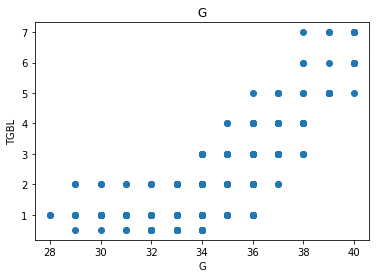

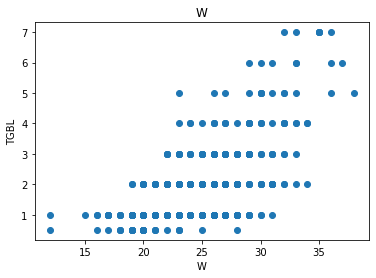

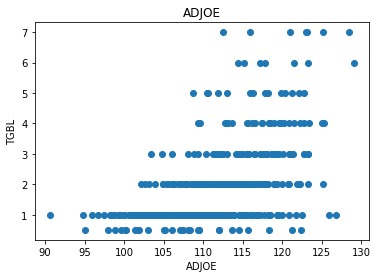

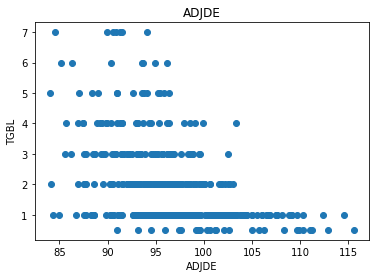

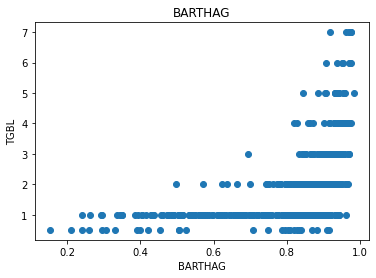

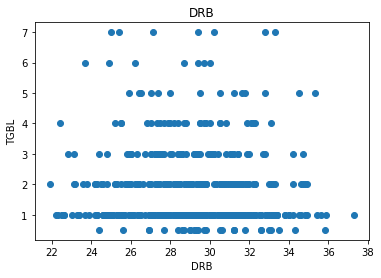

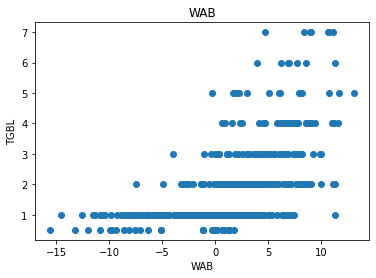

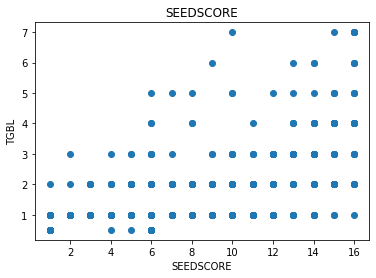

In [136]:
# plotting a scatter plot for each variable with TGBL
for a in empresultX.columns:
    plt.figure()
    plt.title(a)
    plt.ylabel("TGBL")
    plt.xlabel(a)
    plt.scatter(empresultX[a], TGBLdata)
#DRB shows no valuable information, meaning it will not be used

In [98]:
def invfun(X, #input variables
           b1, b2, b3, b4, b5, b6, b7, #fitted amplitudes
           x1, x2, x3, x4, x5, x6, x7): #horizontal shifts 
    
    #assigning independent variables
    G = X["G"].to_numpy()
    W = X["W"].to_numpy()
    ADJOE = X["ADJOE"].to_numpy()
    ADJDE = X["ADJDE"].to_numpy()
    BARTHAG = X["BARTHAG"].to_numpy()
    WAB = X["WAB"].to_numpy()
    SEEDSCORE = X["SEEDSCORE"].to_numpy()
    #DRB did not show good correlation, so not included
    
    Gterm = -b1/(G-max(G)-1-x1) #inverse function found in scatter plot; b1 should be positive
    Wterm = -b2/(W-max(W)-1-x2) #inverse function found in scatter plot; b2 should be positive
    ADJOEterm = -b3/(ADJOE-max(ADJOE)-1-x3) #rough inverse function; b3 should be positive
    ADJDEterm = b4/(ADJDE-min(ADJDE)+1+x4) #rough inverse function; b4 should be positive
    BARTHAGterm = -b5/(BARTHAG-max(BARTHAG)-0.01-x5) #inverse function; b5 should be positive
    WABterm = -b6/(WAB-max(WAB)-0.25-x6) #inverse function; b6 should be positive
    SEEDSCOREterm = -b7/(SEEDSCORE-0.5-x7) #rough inverse function; b7 should be positive
    result = Gterm + Wterm + ADJOEterm + ADJDEterm + BARTHAGterm + WABterm + SEEDSCOREterm
    return(result)

def expfun(X, #input variables
           a1, a2, a3, a4, a5, a6, a7, #fitted amplitudes
           b1, b2, b3, b4, b5, b6, b7, #exponential scales
           x1, x2, x3, x4, x5, x6, x7): #horizontal shifts 
    
    #assigning independent variables
    G = X["G"].to_numpy()
    W = X["W"].to_numpy()
    ADJOE = X["ADJOE"].to_numpy()
    ADJDE = X["ADJDE"].to_numpy()
    BARTHAG = X["BARTHAG"].to_numpy()
    WAB = X["WAB"].to_numpy()
    SEEDSCORE = X["SEEDSCORE"].to_numpy()
    #DRB did not show good correlation, so not included
    
    Gterm = a1*np.exp(b1*(G-max(G)-x1)) #inverse function found in scatter plot; b1 should be positive
    Wterm = a2*np.exp(b2*(W-max(W)-x2)) #inverse function found in scatter plot; b2 should be positive
    ADJOEterm = a3*np.exp(b3*(ADJOE-max(ADJOE)-x3)) #rough inverse function; b3 should be positive
    ADJDEterm = a4*np.exp(-b4*(ADJDE-max(ADJDE)-x4)) #rough inverse function; b4 should be positive
    BARTHAGterm = a5*np.exp(b5*(BARTHAG-max(BARTHAG)-x5)) #inverse function; b5 should be positive
    WABterm = a6*np.exp(b6*(WAB-max(WAB)-x6)) #inverse function; b6 should be positive
    SEEDSCOREterm = a7*np.exp(b7*(SEEDSCORE-max(SEEDSCORE)-x7)) #rough inverse function; b7 should be positive
    result = Gterm + Wterm + ADJOEterm + ADJDEterm + BARTHAGterm + WABterm + SEEDSCOREterm
    return(result)

In [99]:
from scipy.optimize import curve_fit
empirical_inverse_params = curve_fit(f = invfun, xdata = empresultX.drop(columns = "DRB"), ydata = TGBLdata,
                            bounds=([0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                                    [np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf, #b maxes
                                    np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])) #x maxes

empirical_exponential_params = curve_fit(f = expfun, xdata = empresultX.drop(columns = "DRB"), ydata = TGBLdata,
                            bounds=([0,0,0,0,0,0,0,0,0,0,0,0,0,0, #a and b mins
                                    -np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf], #x mins
                                    [np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf, #a maxes
                                     np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf, #b maxes
                                     np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])) #x maxes

In [100]:
empirical_inverse_pred = invfun(empresultX, *empirical_inverse_params[0]) #inverse predictions
empirical_exponential_pred = expfun(empresultX, *empirical_exponential_params[0]) #exponential predictions

In [101]:
from sklearn.metrics import r2_score

print("Empirical Inverse Model R-Squared: " + str(r2_score(TGBLdata, empirical_inverse_pred))) #inv r-squared
print("Empirical Exponential Model R-Squared: " + str(r2_score(TGBLdata, empirical_exponential_pred))) #exp r-squared

Empirical Inverse Model R-Squared: 0.6802266714456413
Empirical Exponential Model R-Squared: 0.7701921906115068


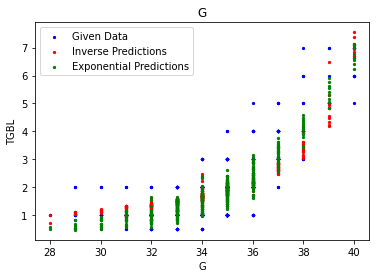

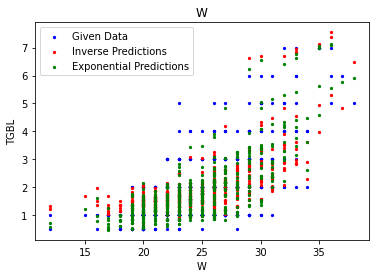

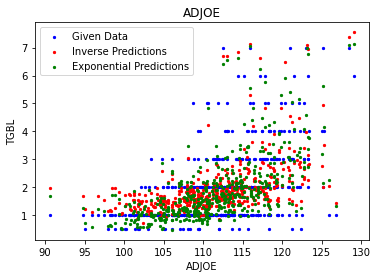

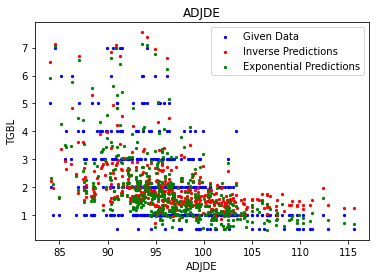

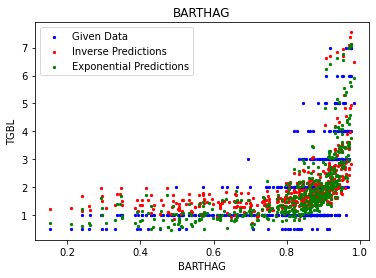

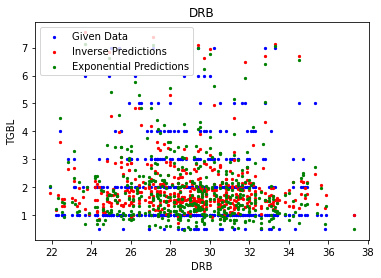

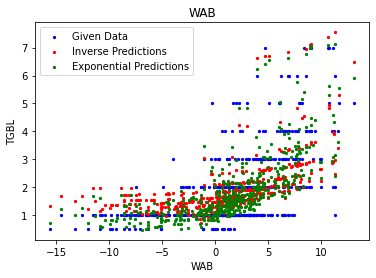

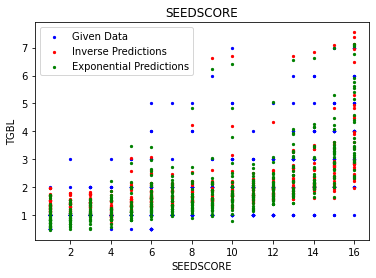

In [137]:
for a in empresultX.columns:
    plt.figure() #plotting new figure through each loop
    plt.title(a) #plotting title as column name
    plt.xlabel(a)
    plt.ylabel("TGBL")
    plt.scatter(empresultX[a], TGBLdata, c = 'b', s = 5, label = "Given Data") #recorded data
    plt.scatter(empresultX[a], empirical_inverse_pred, c = 'r', s = 5, label = "Inverse Predictions") #inverse function points
    plt.scatter(empresultX[a], empirical_exponential_pred, c = 'g', s = 5, label = "Exponential Predictions") #exponential function points
    plt.legend() #plotting the legend for each plot

In [103]:
newresultX.head()

,G,W,ADJOE,ADJDE,BARTHAG,DRB,WAB,SEEDSCORE
0,24,20,118.1,91.1,0.9521,24.8,7.2,16.0
1,24,22,123.2,94.5,0.9548,30.9,6.6,16.0
2,29,23,117.7,90.4,0.9539,22.2,8.9,16.0
3,26,26,125.4,89.8,0.9791,23.4,8.5,16.0
4,29,21,123.5,95.7,0.9491,28.6,5.6,15.0


In [105]:
ly_inv_pred = invfun(newresultX, *empirical_inverse_params[0]) #2021 inverse predictions
ly_exp_pred = expfun(newresultX, *empirical_exponential_params[0]) #2021 exponential predictions

In [106]:
#Baylor Prediction:
print("Empirical Inverse Model TGBL Prediction for Baylor: " + str(ly_inv_pred[1].astype(int))) #inverse
print("Empirical Exponential Model TGBL Prediction for Baylor: " + str(ly_exp_pred[1].astype(int))) #exponential

Empirical Inverse Model TGBL Prediction for Baylor: 2
Empirical Exponential Model TGBL Prediction for Baylor: 2


In [115]:
#2 Seed Alabama Prediction (Highest TGBL prediction for Inverse and Exponential)
print("Empirical Inverse Model TGBL Prediction for Alabama: " + str(ly_inv_pred[7].astype(int))) #inverse
print("Empirical Exponential Model TGBL Prediction for Alabama: " + str(ly_exp_pred[7].astype(int))) #exponential
print("Actual Tournament Results: Sweet Sixteen (TGBL: 3); Lost to UCLA")

Empirical Inverse Model TGBL Prediction for Alabama: 7
Empirical Exponential Model TGBL Prediction for Alabama: 6
Actual Tournament Results: Sweet Sixteen (TGBL: 3); Lost to UCLA
